<a href="https://colab.research.google.com/github/yannmean/Artificial-Intelligence_CS221-2023-FALL/blob/main/OngigModelsForAdverbScore_YM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. House keeping

This section is mainly for setting up the environment, installing and loading packages, setting up the working directly on Google Drive.

Please note that colab is make for python by default, but I created a R environment within (some people call it "the r magic"). So the codes are still written in R. 

In [ ]:
# Mount to my googled drive directory which contains the original dataset, and the ridge coefficients
from google.colab import drive
drive.mount('/content/drive')
# Here I created this directory in my google drive to host all the objects needed for this computation
%cd /content/drive/MyDrive/Ongig/ 
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Ongig
adverbsCounts.csv	   adverb-weight-dataset_newAdvScores.csv
adverbs.csv		   jobPostWordVector.pdf
adverb-weight-dataset.csv  ridgeAdvCoefs.csv


In [ ]:
%%capture
# activate R in python console
!pip install rpy2==3.5.1

In [ ]:
# Load R environment
%load_ext rpy2.ipython

In [ ]:
%%R
# install and load necessary packages and load from library

install.packages("dplyr")
install.packages("reshape")
install.packages("ggplot2")
install.packages("tidyr")

pkgs <- c("dplyr", "reshape", "ggplot2", "tidyr")
sapply(pkgs, require, character.only = T)

# 1. Compute the Adverb Score

## 1.1 Introduction 
To obtain the adverb score for one job posting, we need the following three components: 

1) the weight of each adverb that exist in this job posting;\
2) the number of times each adverb has appeared in the same job posting;\
3) the total number of adverbs in the same job posting

The first component - weight of each adverb - has been obtained via a statistical learning method, ridge regression, and stored as a dataframe of two variables: 

*   advScore - the weight (stored as float)
*   adv - the adverbs (stored as string)

The second component - adverb frequency in each job posting - has been obtained by counting the number of each adverb that appeared in a given job posting.

Finally, the third component - total number of adverbs - is calculated by counting the total number of adverbs (if one adverb appeared twice, we count it as 2, instead of 1.)

## 1.2 Adverb Score Construction

First, let's clarify the notations 


*   Let $s_i$ be the adverb score for job posting $i$
*   Let $w_j$ be the ridge coefficient of adverb $j$ (a.k.a. the "weight")
*   Let $n_{ij}$ be the frequency count of adverb $j$ in job posting $i$
*   Let $N_i$ be the total number of adverbs in job posting $i$

Therefore, the adverb score of job posting j can be calculated as the following:

\begin{align}
 s_i = \sum_{j} w_j \frac{n_{ij}}{N_i} 
\end{align}

In other words, the adverb score is the sum of the weighted adverb frequencies of the adverbs that are from the job posting.

## 1.3 Data Preparation for Computation
In the actual computation, we will not compute the adverb score for each job posting one-by-one, as this is not efficient and will take too long when we have millions of adverb scores that we would like to compute. Rather we formulate the computation into a Hadamard product of two matrices (element-wise multiplication), hence the computation is much faster. 

### 1.3.1 First, we need to prepare our dataset by creating the adverb frequency table by parsing, counting adverbs for each posting. 

There are three objects which need to be pre-loaded:
*   The original dataset (adverb-weight-dataset.csv)
*   The master adverb list from Ongig (adverbs.csv)
*   The adverb weights (ridgeAdvCoefs.csv)

In [ ]:
%%R
# load the original dataset
df <- read.csv("adverb-weight-dataset.csv")

# load the master list of adverbs
advList <- read.csv("adverbs.csv", header = F)

# load the adverb weights
ridge_weights <- read.csv("ridgeAdvCoefs.csv")

In [ ]:
%%R
# subset the dataset to only include "job_id" and "adverbs"
df_adv <- df[, c("job_id", "adverbs")] 
df_adv$adverbs <- gsub(" ", "", df_adv$adverbs)
# note the largest number of adverbs that one posting has is 64.
df_adv <- df_adv %>% separate(adverbs, paste0("adv", c(1:64)), sep = ",", remove = T)

# obtain adverbs from the current job posting
adverbsFromPosting <- unique(as.vector(as.matrix(df_adv[,2:ncol(df_adv)])))
adverbsFromPosting <- adverbsFromPosting[adverbsFromPosting!= "" & !is.na(adverbsFromPosting)] 

# create a data frame to hold adverb frequencies for each job posting
df_advCounts <- data.frame(matrix(0, ncol = nrow(advList) + 1, nrow = nrow(df)))
colnames(df_advCounts) <- c("job_id", advList$V1)

# this step might take 1 minute or 2 
for (i in 1:nrow(df_adv)) {
  df_advCounts[i, "job_id"] = df_adv$job_id[i]
  df_adv_temp <- df_adv[i,]
  df_adv_temp <- df_adv_temp[!is.na(df_adv_temp)]
  
  # inner loop start from the second index as the first index is the job_id
  for (j in 2:length(df_adv_temp)) {
    col_index <- which(colnames(df_advCounts) == df_adv_temp[j])
    df_advCounts[i, col_index] <-  df_advCounts[i, col_index] + 1  
  }
}

In [ ]:
%%R
# df_advCounts dataframe contains all the adverbs, however there are many adverbs 
# from the master adverb lists do not exist in current job postings, here we only
# keep the adverbs that have appeared in the current job postings. 
df_advCounts <- df_advCounts[, colnames(df_advCounts) %in% adverbsFromPosting]
df_advCounts$job_id <- df_adv$job_id

# compute the total number of adverbs in each job posting, and store that value in variable "advTotal"
df_advCounts$advTotal <- rowSums(df_advCounts[, !names(df_advCounts) %in% c("job_id", "advTotal")])

# sanity check the dimension of this dataframe, the number of colum should be 534 adverbs + job_id + adv_total
dim(df_advCounts)

[1] 42642   536


### 1.3.2 We store a version of the adverb frequency table for future use. (In case this session is timed-out, we also don't have to reconstruct it.)

In [ ]:
%%R
# Now that this dataset should be saved in the google drive folder
write.csv(df_advCounts, file = "/content/drive/MyDrive/Ongig/adverbsCounts.csv") 

### 1.3.3 Now we need to make sure the ridge_weights matrix (the weight matrix) and the df_advCounts matrix (the frequency matrix) have the same dimension, and all adverbs are following the same orders along the column. 


In [ ]:
%%R
# obtain the number of job postings we have
n = nrow(df_advCounts)

# we broadcast the ridge_weights following the dimension of the adverb frequency matrix, df_advCounts
ridge_weights_expand <- cbind(ridge_weights, rep(ridge_weights[2], each = n)) %>% t() %>% as.data.frame()
ridge_weights_expand <- ridge_weights_expand[3:nrow(ridge_weights_expand), 3:ncol(ridge_weights_expand)] 
colnames(ridge_weights_expand) <- ridge_weights_expand[1,]
ridge_weights_expand <- ridge_weights_expand[-1,]
ridge_weights_expand <- ridge_weights_expand[,!colnames(ridge_weights_expand) %in% c("job_id", "advTotal")]
# sanity check the dimension of ridge_weights_expand
dim(ridge_weights_expand)

# re-order the columns to make sure adverbs in the weight matrix follow the same order
ridge_weights_expand <- ridge_weights_expand[, order(colnames(ridge_weights_expand))] 

ridge_weights_expand <- as.matrix(sapply(ridge_weights_expand, as.numeric))

### 1.3.4 Now make sure the frequency matrix is having the same dimension and the same adverb ordering as the weight matrix.



In [ ]:
%%R
# First double check that all adverbs from df_advCounts are included in the weight matrix
df_advCounts <- df_advCounts[,colnames(df_advCounts) %in% colnames(ridge_weights_expand) & ! colnames(df_advCounts) %in% c("job_id", "advTotal")]

# make sure the adverbs follow the same order
df_advCounts <- df_advCounts[, order(colnames(df_advCounts))]

df_advCounts <- as.matrix(sapply(df_advCounts, as.numeric))
# sanity check of the dimension 
dim(df_advCounts)

[1] 42642   534


## 1.4 Adverb Score Computation







In [ ]:
%%R
# Step 1. compute the Hadamard product of the weight matrix and the frequency matrix (element-wise products) 
# call this the adverb raw score
advRawScores <- ridge_weights_expand * df_advCounts 

# sanity check for dimention
dim(advRawScores)

[1] 42642   534


In [ ]:
%%R
# Step 2. compute the sum of the raw scores
advRawScoresSum <- rowSums(advRawScores)

# Step 3. reweight the raw score by the total number of advs 
advScoresNew <- advRawScoresSum/rowSums(df_advCounts)

# Step 4. set the advScoresNew as 0 for those postings without any adverbs
advScoresNew[is.na(advScoresNew)] = 0

# Step 5. merge the new score back into the original dataset for future use
df$advScoresNew <- advScoresNew

In [ ]:
%%R
# save a version of the updated dataset
write.csv(df, file = "/content/drive/MyDrive/Ongig/adverb-weight-dataset_newAdvScores.csv")

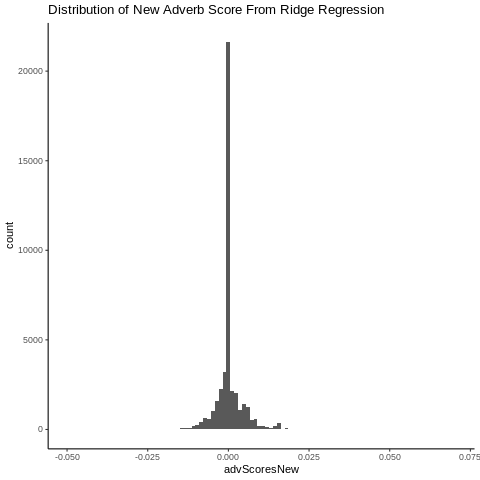

In [ ]:
%%R
# Vistualizee the distribution of the new adverb score
ggplot(df, aes(x = advScoresNew)) + geom_histogram(bins = 100) + theme_classic() + ggtitle("Distribution of New Adverb Score From Ridge Regression")

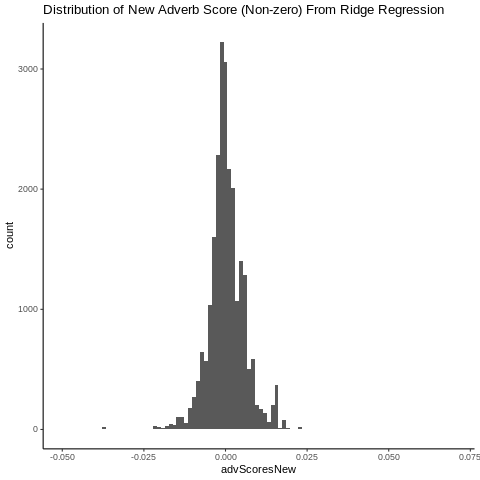

In [ ]:
%%R
# Vistualizee the distribution again, but removing all the zeros
ggplot(df[df$advScoresNew!=0,], aes(x = advScoresNew)) + geom_histogram(bins = 100) + theme_classic() + ggtitle("Distribution of New Adverb Score (Non-zero) From Ridge Regression")

## 1.5 Rescale the new adver score to 0 to 100

In [ ]:
%%R
# reload the previously safe the dataset if the session logs out. 
# df <- read.csv("/content/drive/MyDrive/Ongig/adverb-weight-dataset_newAdvScores.csv")

as <- df$advScoresNew

### 1.5.1 arctan transformation 


In [ ]:
%%R
# scale by 100 so that arctan (x) is more spread across the whole range pf -3.14/2, 3.14/2
as_arctan <- atan(as*100) 
summary(as_arctan)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.37052 -0.06273  0.00000  0.01452  0.04401  1.42822 


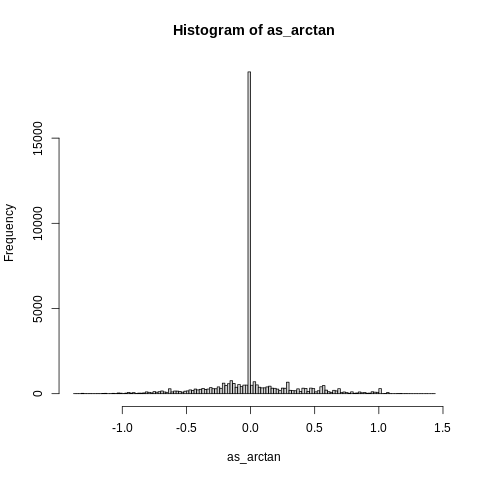

In [ ]:
%%R
hist(as_arctan, breaks = 100)

### 1.5.2 compute z score

In [ ]:
%%R
mean <- mean(as_arctan)
sd <- sd(as_arctan)
as_arc_z <- (as_arctan - mean) / sd
summary(as_arc_z)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-4.23689 -0.23631 -0.04443  0.00000  0.09020  4.32455 


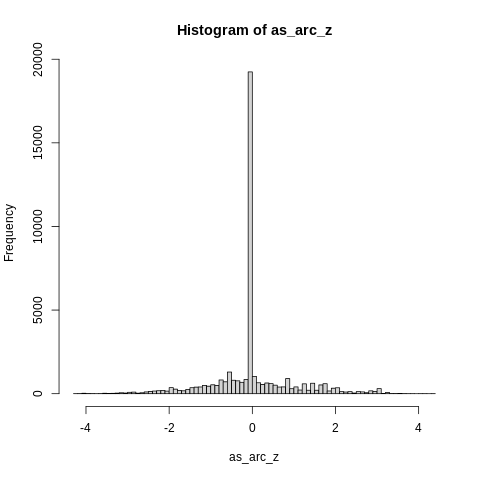

In [ ]:
%%R
hist(as_arc_z, breaks = 100)

### 1.5.3 shift the distribution from range (-$\pi$/2, $\pi$/2), to (0, 100)

In [ ]:
%%R
# by symmmetry, the mean of a symmetric distribution on (0, 100) should be 50
as_rescaled <- 50 + as_arc_z*(sd*30) # rescale sd by 30 to spread on the new domain
summary(as_rescaled)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  8.449  47.683  49.564  50.000  50.885  92.411 


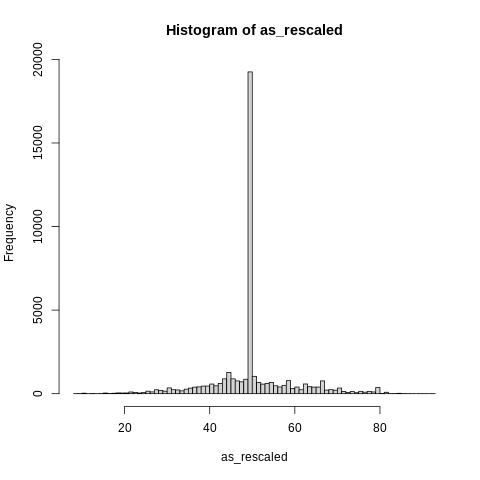

In [ ]:
%%R
hist(as_rescaled, breaks = 100)

### 1.5.4 for those smaller than zero are set at zero, larger than 100 are set at 100 (didn't happen in our current case), it might happen in future with very small probability (4 standard deviation from the mean)

In [ ]:
%%R
as_rescaled[as_rescaled < 0] = 0
as_rescaled[as_rescaled > 100] = 100

### 1.5.5 testing and evaluation the new rescaled adv score:

#### create variables needed for the evaluations

In [ ]:
%%R
df$as_rescaled <- as_rescaled
df$unique_apply_rate <- df$unique_applystarts / df$unique_views
df$word_count_sqr <- df$word_count * df$word_count

#### examine correlation betweent rescaled and the unscaled new adverb score.

In [ ]:
%%R
cor(df$advScoresNew, df$as_rescaled)

[1] 0.969589


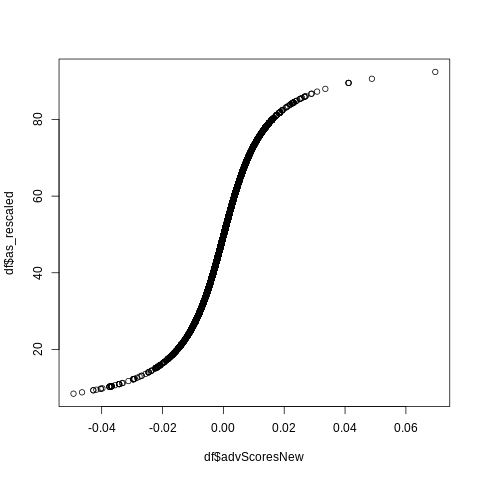

In [ ]:
%%R
plot(df$advScoresNew, df$as_rescaled) # monotonic transformation, sigma curve

#### predicting the outcome - unique application rate (uptake), compared with the new adverb score that hasn't been rescaled.

In [ ]:
%%R
lm_new_adv_score <- lm(unique_apply_rate ~ advScoresNew + word_count + word_count_sqr + title + title*advScoresNew, data = df)
lm_new_adv_score_rescale <- lm(unique_apply_rate ~ as_rescaled + word_count + word_count_sqr + title + title*as_rescaled, data = df)

In [ ]:
%%R
# new adverb score (unscaled)
summary(lm_new_adv_score)


Call:
lm(formula = unique_apply_rate ~ advScoresNew + word_count + 
    word_count_sqr + title + title * advScoresNew, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40406 -0.08302 -0.00588  0.07520  0.78647 

Coefficients:
                                           Estimate Std. Error t value Pr(>|t|)
(Intercept)                               2.220e-01  1.979e-03 112.178  < 2e-16
advScoresNew                              3.784e+00  3.686e-01  10.265  < 2e-16
word_count                               -2.611e-05  6.308e-06  -4.139 3.49e-05
word_count_sqr                           -7.680e-09  5.208e-09  -1.475   0.1403
titleRetail Sales Associate               2.223e-02  1.785e-03  12.455  < 2e-16
titleSales Associate                      2.658e-02  1.944e-03  13.669  < 2e-16
titleShift Leader                         3.726e-02  2.494e-03  14.940  < 2e-16
titleShift Manager                        4.176e-02  2.560e-03  16.310  < 2e-16
titleTruck Driver             

In [ ]:
%%R
# new adverb score (rescaled)
summary(lm_new_adv_score_rescale)


Call:
lm(formula = unique_apply_rate ~ as_rescaled + word_count + word_count_sqr + 
    title + title * as_rescaled, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.34372 -0.08242 -0.00599  0.07536  0.79425 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                              1.378e-01  8.053e-03  17.107  < 2e-16
as_rescaled                              1.711e-03  1.593e-04  10.745  < 2e-16
word_count                              -2.818e-05  6.307e-06  -4.467 7.95e-06
word_count_sqr                          -6.330e-09  5.207e-09  -1.216 0.224100
titleRetail Sales Associate             -3.347e-02  9.837e-03  -3.403 0.000668
titleSales Associate                    -2.265e-02  1.139e-02  -1.989 0.046702
titleShift Leader                        4.071e-02  1.398e-02   2.911 0.003601
titleShift Manager                       1.507e-02  1.480e-02   1.018 0.308848
titleTruck Driver                       -

In [ ]:
%%R
# anova on new adverb score (unscaled)
anova(lm_new_adv_score)

Analysis of Variance Table

Response: unique_apply_rate
                      Df Sum Sq Mean Sq  F value    Pr(>F)    
advScoresNew           1  37.13  37.134 2324.450 < 2.2e-16 ***
word_count             1   0.71   0.712   44.553 2.507e-11 ***
word_count_sqr         1   0.32   0.322   20.133 7.245e-06 ***
title                  5  61.59  12.319  771.094 < 2.2e-16 ***
advScoresNew:title     5   3.03   0.606   37.940 < 2.2e-16 ***
Residuals          42628 681.01   0.016                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
# anova on new adverb score (rescaled)
anova(lm_new_adv_score_rescale)

Analysis of Variance Table

Response: unique_apply_rate
                     Df Sum Sq Mean Sq  F value    Pr(>F)    
as_rescaled           1  39.32  39.317 2462.911 < 2.2e-16 ***
word_count            1   0.72   0.723   45.317 1.697e-11 ***
word_count_sqr        1   0.29   0.288   18.060 2.145e-05 ***
title                 5  59.93  11.986  750.837 < 2.2e-16 ***
as_rescaled:title     5   3.04   0.608   38.076 < 2.2e-16 ***
Residuals         42628 680.50   0.016                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## 1.6 Notes on Adverb Score


*   Rescaled new adverb score slightly outperforms the new adverb score without scaling.
*   This version computes adverb scores only based on the adverbs that the training algorithm has "seen." Adverbs that the algorithm hasn't seen before are not included in the computation. (Note: we can build algorithms which can address "unseen" adverbs if you want.)
*   Some job postings ( $\sim$ 43.5 %) do not contain any adverb, therefore their adverb score is defined as 0.  



# 2. Gender Score

(coming soon)